## Multiplier Over Time

#### Config

In [62]:
## load some packages
from pandas_datareader.fred import FredReader  # gets data without a bunch of csvs
from scipy.signal import detrend  # detrend series
import matplotlib.pyplot as plt  # make plots
import statsmodels.api as sm  # regressions
import numpy as np  # math things

# fonts look pretty
plt.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
    })

#### Data

In [63]:
## data config
start = '1940-01'
end = '2019-12'
series = {
        'GDPDEF': 'gdpdef',  # gdp deflator
        'GDP': 'gdp',  # gdp
        'GCE': 'gov',  # govt spending
        'W006RC1Q027SBEA': 'tax',  # tax revenues
    }

## pull data
## pull the data
df = FredReader(series.keys(), start=start, end=end).read().rename(columns=series).dropna()

## adjust series
df = df[['gdp', 'gov', 'tax']].div(df['gdpdef'], axis=0)
# # predetrend, want to know how much higher gdp is than gov
# # so when we know 1% change in gov -> 1% change in gdp we can muliply it by that
# mult = (df['gdp'] / df['gov']).mean()
# for x in df.columns:
#     df[x] = detrend(np.log(df[x])) * 100

df

,gdp,gov,tax
DATE,,,
1947-01-01,21.826048,3.614936,3.308500
1947-04-01,21.769006,3.552350,3.214090
1947-07-01,21.723823,3.425973,3.156410
1947-10-01,22.064645,3.358308,3.291199
1948-01-01,22.397134,3.445006,3.282933
...,...,...,...
2018-10-01,203.048632,35.438579,20.084732
2019-01-01,204.316352,35.836695,20.128542
2019-04-01,206.022780,36.213851,20.103955


#### Estimate Multiplier

In [64]:
def get_mult(df, A, B, T=25):
    ## data celaning
    mult = (df['gdp'] / df['gov']).mean()
    df = df.copy()
    for x in df.columns:
        df[x] = detrend(np.log(df[x])) * 100
    
    # calcaute svar
    svar = sm.tsa.SVAR(df, svar_type='AB', A=A, B=B).fit(maxlags=4, solver='ncg')

    # get the irf
    irf = svar.irf(periods=T)
    g_irf = irf.svar_irfs[:, :, 2].T  # irf for a g shock
    g_irf /= g_irf[2, 0]
    g_irf_err = irf.stderr()[:, :, 2].T / g_irf[2, 0]  # error band

    ## get the multiplier
    idx = np.abs(g_irf[0]).argmax()
    max_gdp_change = g_irf[0, idx]
    max_gdp_stderr = g_irf_err[0, idx]
    multiplier = max_gdp_change * mult  # make comprable units
    multiplier_err = max_gdp_stderr * mult

    return multiplier, multiplier_err

#### Model 1

/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method ncg is: fhess_p, avextol, epsilon. The list of unsupported keyword arguments passed include: gtol. After release 0.14, this will raise.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, f

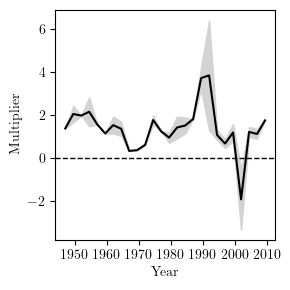

In [65]:
## config
A = np.array([[1, 'E', 'E'], [0, 1, 0], [1.7, 0, 1]])
B = np.array([[1, 0, 0], [0, 1, 0], [0, 'E', 1]])
period = 40
interval = 10

## estimate
ts = np.arange(0, len(df) - period, interval)
multipliers = []
multiplier_errs = []
for i in ts:
    m, me = get_mult(df[i:i + period], A, B)
    multipliers.append(m)
    multiplier_errs.append(me)
multipliers = np.array(multipliers)
multiplier_errs = np.array(multiplier_errs)

## plot it
fig, ax = plt.subplots()
fig.set_figwidth(3)
fig.set_figheight(3)
ax.set_ylabel('Multiplier')
ax.set_xlabel('Year')

# plot the data
ax.fill_between(
        df.iloc[ts].index,
        multipliers - multiplier_errs,
        multipliers + multiplier_errs,
        color='lightgray',
    )
ax.plot(df.iloc[ts].index, multipliers, 'k-')
ax.axhline(0, ls='--', c='k', lw=1)

## final things
fig.tight_layout()
fig.savefig('paper/figures/b20_ts.pdf')

#### Model 2

/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method ncg is: fhess_p, avextol, epsilon. The list of unsupported keyword arguments passed include: gtol. After release 0.14, this will raise.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
/opt/miniconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, f

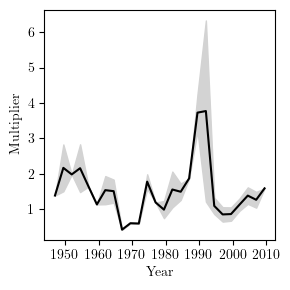

In [66]:
## config
A = np.array([[1, 'E', 'E'], [0, 1, 0], [1.7, 0, 1]])
B = np.array([[1, 0, 0], [0, 1, 'E'], [0, 0, 1]])
period = 40
interval = 10

## estimate
ts = np.arange(0, len(df) - period, interval)
multipliers = []
multiplier_errs = []
for i in ts:
    m, me = get_mult(df[i:i + period], A, B)
    multipliers.append(m)
    multiplier_errs.append(me)
multipliers = np.array(multipliers)
multiplier_errs = np.array(multiplier_errs)

## plot it
fig, ax = plt.subplots()
fig.set_figwidth(3)
fig.set_figheight(3)
ax.set_ylabel('Multiplier')
ax.set_xlabel('Year')

# plot the data
ax.fill_between(
        df.iloc[ts].index,
        multipliers - multiplier_errs,
        multipliers + multiplier_errs,
        color='lightgray',
    )
ax.plot(df.iloc[ts].index, multipliers, 'k-')

## final things
fig.tight_layout()
fig.savefig('paper/figures/c20_ts.pdf')